In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 10
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L1VzZXJzL211bGxpbnNqL0Ryb3Bib3gvVGVhY2hpbmcvRUNPTjQ1MzgvbGVjdHVyZXM="
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


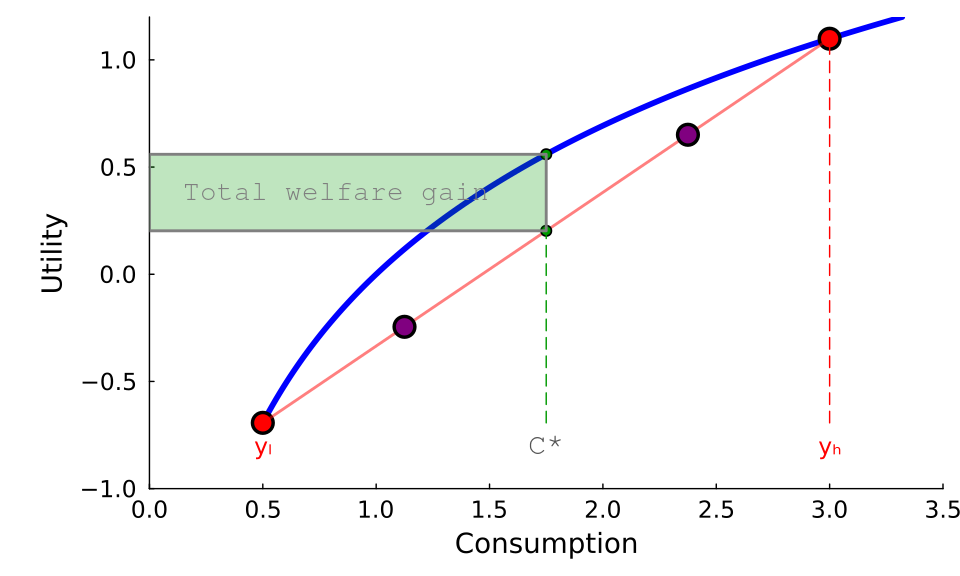

In [2]:
#| echo: false

using Plots

# Parameters
y_L = 0.5
y_H = 3.0
π = 0.75  # probability of low income for low type

# Calculate key values
C_star = 0.5*y_H + 0.5*y_L
W_0 = 0.5*log(y_L) + 0.5*log(y_H)  # E[log(y)] - laissez-faire
U_L = π*log(y_L) + (1-π)*log(y_H)  # Utility of type L
U_H = π*log(y_H) + (1-π)*log(y_L)  # Utility of type H
E_L = π*y_L + (1-π)*y_H            # Expected income type L
E_H = π*y_H + (1-π)*y_L            # Expected income type H
c_L = exp(U_L)                      # Certainty equivalent type L
c_H = exp(U_H)                      # Certainty equivalent type H
U_star = log(C_star)                # Utility with perfect insurance
C_bar = 0.5*c_L + 0.5*c_H          # Average certainty equivalent

# Create the plot
y_range = range(0.5, 3.5, length=200)
y_left = 0.
y_width = C_star
y_min = log(y_L)

p = plot(y_range, log.(y_range),
     label="u(c) = log(c)",
     linewidth=4,
     color=:blue,
     xlabel="Consumption",
     ylabel="Utility",
     legend=:bottomright,
     size=(1000, 600),
     grid=false,
     thickness_scaling=1.5,
     legendfontsize=10,
     guidefontsize=13,
     tickfontsize=11,
     xlims=(0., 3.5),
     ylims=(-1., 1.2))

# Income realizations
scatter!([y_L, y_H], [log(y_L), log(y_H)],
         markersize=8, color=:red, markerstrokewidth=2, label="Income realizations")
plot!([y_L, y_H], [log(y_L), log(y_H)], color=:red, linewidth=2, alpha=0.5, label="")
plot!([y_H,y_H],[y_min,log(y_H)],linestyle=:dash, color=:red)

# Welfare levels
# plot!([0, C_star], [W_0, W_0], linestyle=:dash, color=:red, linewidth=2.5,
#       label="E[log(y)] - Laissez-faire")
# plot!([0, C_star], [U_star, U_star], linestyle=:dash, color=RGB(0, 0.6, 0),
#       linewidth=2.5, label="log(C*) - Perfect insurance")
scatter!([E_L, E_H], [U_L, U_H], markersize=8, color=:purple,
         markerstrokewidth=2)
scatter!([C_star,C_star],[W_0,U_star], color=RGB(0, 0.6, 0))
plot!([C_star,C_star],[y_min,U_star],linestyle=:dash,color=RGB(0, 0.6, 0))

# Annotations
annotate!(y_L, -0.8, text("yₗ", :red, :center, 11))
annotate!(y_H, -0.8, text("yₕ", :red, :center, 11))
annotate!(C_star, -0.8, text("C*", RGB(0, 0.6, 0), :center, 11, :bold))

# Total gain shading
plot!([y_left, y_left+y_width, y_left+y_width, y_left, y_left],
      [W_0, W_0, U_star, U_star, W_0], fillrange=W_0,
      fillalpha=0.25, fillcolor=RGB(0, 0.6, 0), linecolor=:gray, linewidth=2, label="")
annotate!(0.15, (W_0 + U_star)/2,
          text("Total welfare gain", :gray, :left, 10, :bold))

plot!(legend=false)

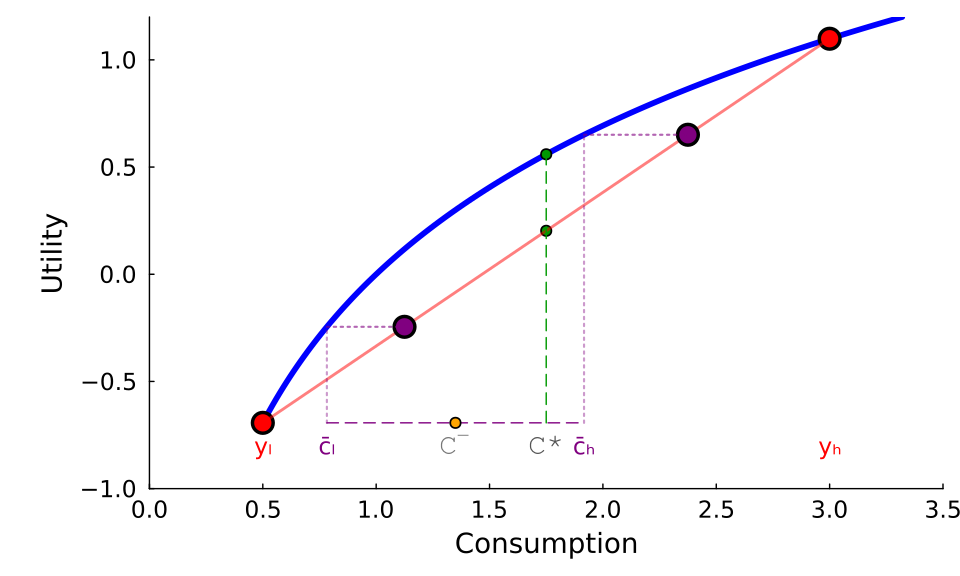

In [3]:
#| echo: false

p = plot(y_range, log.(y_range),
     label="u(c) = log(c)",
     linewidth=4,
     color=:blue,
     xlabel="Consumption",
     ylabel="Utility",
     legend=:bottomright,
     size=(1000, 600),
     grid=false,
     thickness_scaling=1.5,
     legendfontsize=10,
     guidefontsize=13,
     tickfontsize=11,
     xlims=(0., 3.5),
     ylims=(-1., 1.2))

# Income realizations
scatter!([y_L, y_H], [log(y_L), log(y_H)],
         markersize=8, color=:red, markerstrokewidth=2, label="Income realizations")
scatter!([C_star,C_star],[W_0,U_star], color=RGB(0, 0.6, 0))
plot!([y_L, y_H], [log(y_L), log(y_H)], color=:red, linewidth=2, alpha=0.5, label="")

# Welfare levels

# Add certainty equivalents
scatter!([E_L, E_H], [U_L, U_H], markersize=8, color=:purple,
         markerstrokewidth=2, label="Type certainty equivalents")
plot!([c_L, E_L], [U_L, U_L], color=:purple, linewidth=1.5, alpha=0.6, linestyle=:dot, label="")
plot!([c_H, E_H], [U_H, U_H], color=:purple, linewidth=1.5, alpha=0.6, linestyle=:dot, label="")
plot!([c_L, c_L], [y_min, U_L], color=:purple, linewidth=1.5, alpha=0.4, linestyle=:dot, label="")
plot!([c_H, c_H], [y_min, U_H], color=:purple, linewidth=1.5, alpha=0.4, linestyle=:dot, label="")
plot!([C_star,C_star],[y_min,U_star],linestyle=:dash,color=RGB(0, 0.6, 0))
plot!([c_L,c_H],[y_min,y_min],color=:purple, linestyle=:dash)
scatter!([C_bar],[y_min],color=:orange)

# # Average certainty equivalent
# plot!([0, C_bar], [log(C_bar), log(C_bar)], linestyle=:dash, color=:orange,
#       linewidth=2.5, label="log(C̄) - Avg certainty equiv")
# plot!([C_bar, C_bar], [-0.5, log(C_bar)], color=:orange, linewidth=2,
#       alpha=0.5, linestyle=:dot, label="")

# Annotations
annotate!(c_L, -0.8, text("c̄ₗ", :purple, :center, 11))
annotate!(c_H, -0.8, text("c̄ₕ", :purple, :center, 11))
annotate!(C_bar, -0.8, text("C̄", :orange, :center, 11, :bold))
annotate!(C_star, -0.8, text("C*", RGB(0, 0.6, 0), :center, 11, :bold))
annotate!(y_L, -0.8, text("yₗ", :red, :center, 11))
annotate!(y_H, -0.8, text("yₕ", :red, :center, 11))

plot!(legend=false)

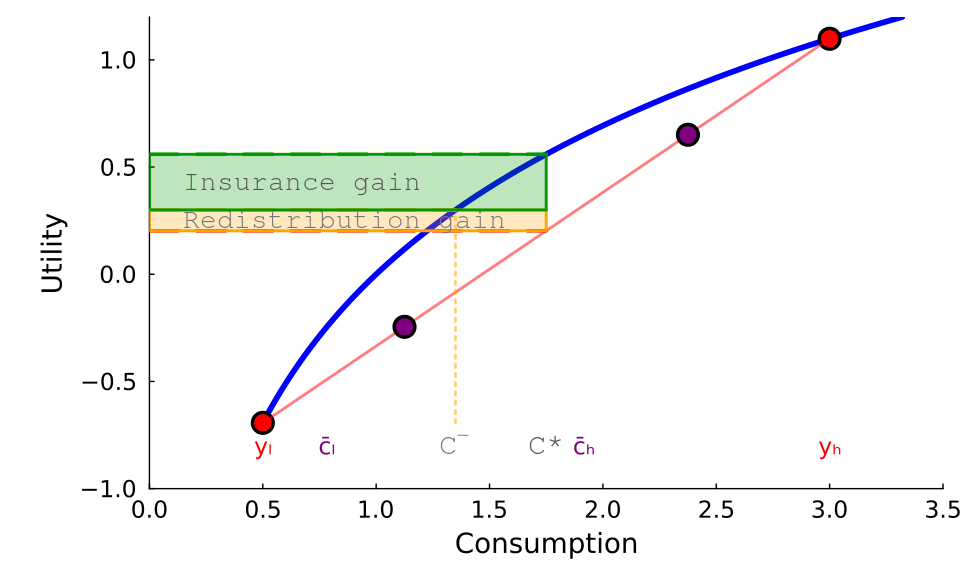

In [4]:
#| echo: false

p = plot(y_range, log.(y_range),
     label="u(c) = log(c)",
     linewidth=4,
     color=:blue,
     xlabel="Consumption",
     ylabel="Utility",
     legend=:bottomright,
     size=(1000, 600),
     grid=false,
     thickness_scaling=1.5,
     legendfontsize=10,
     guidefontsize=13,
     tickfontsize=11,
     xlims=(0., 3.5),
     ylims=(-1., 1.2))

# Income realizations
scatter!([y_L, y_H], [log(y_L), log(y_H)],
         markersize=8, color=:red, markerstrokewidth=2, label="Income realizations")
plot!([y_L, y_H], [log(y_L), log(y_H)], color=:red, linewidth=2, alpha=0.5, label="")

# Welfare levels
plot!([0, C_star], [W_0, W_0], linestyle=:dash, color=:red, linewidth=2.5,
      label="E[log(y)] - Laissez-faire")
plot!([0, C_bar], [log(C_bar), log(C_bar)], linestyle=:dash, color=:orange,
      linewidth=2.5, label="log(C̄) - Redistribution")
plot!([0, C_star], [U_star, U_star], linestyle=:dash, color=RGB(0, 0.6, 0),
      linewidth=2.5, label="log(C*) - Perfect insurance")

# Certainty equivalents
scatter!([E_L, E_H], [U_L, U_H], markersize=8, color=:purple,
         markerstrokewidth=2, label="Type certainty equivalents")
plot!([C_bar, C_bar], [y_min, log(C_bar)], color=:orange, linewidth=2,
      alpha=0.5, linestyle=:dot, label="")

# Annotations
annotate!(c_L, -0.8, text("c̄ₗ", :purple, :center, 11))
annotate!(c_H, -0.8, text("c̄ₕ", :purple, :center, 11))
annotate!(C_bar, -0.8, text("C̄", :orange, :center, 11, :bold))
annotate!(C_star, -0.8, text("C*", RGB(0, 0.6, 0), :center, 11, :bold))
annotate!(y_L, -0.8, text("yₗ", :red, :center, 11))
annotate!(y_H, -0.8, text("yₕ", :red, :center, 11))

# Decomposition shading
plot!([y_left, y_left+y_width, y_left+y_width, y_left, y_left],
      [W_0, W_0, log(C_bar), log(C_bar), W_0], fillrange=W_0,
      fillalpha=0.25, fillcolor=:orange, linecolor=:orange, linewidth=2, label="")
plot!([y_left, y_left+y_width, y_left+y_width, y_left, y_left],
      [log(C_bar), log(C_bar), U_star, U_star, log(C_bar)], fillrange=log(C_bar),
      fillalpha=0.25, fillcolor=RGB(0, 0.6, 0), linecolor=RGB(0, 0.6, 0),
      linewidth=2, label="")

annotate!( 0.15, (W_0 + log(C_bar))/2,
          text("Redistribution gain", :orange, :left, 10, :bold))
annotate!( 0.15, (log(C_bar) + U_star)/2,
          text("Insurance gain", RGB(0, 0.6, 0), :left, 10, :bold))

plot!(legend=false)